In [26]:
import pathlib
import os
from PIL import Image

import torch
from torchvision import models, datasets, transforms

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px

import pickle
from sklearn.decomposition import IncrementalPCA

In [27]:
# create a dataset and dataloader for the data
data_dir_train = pathlib.Path('../../data/skincancer_new_processed/train/images')
data_dir_test = pathlib.Path('../../data/skincancer_new_processed/test/images')
data_dir_val = pathlib.Path('../../data/skincancer_new_processed/val/images')

In [28]:
# read each image from the folder and convert it to a numpy array, center crop it and flatten it, add it to the dataset
def create_dataset(data_dir):
    index = []
    dataset = []
    path = data_dir
    for img in path.iterdir():
        index.append(str(img).split('/')[-1].split('.')[0])
        dataset.append(np.array(Image.open(img)).flatten().reshape(1, -1))
    return dataset, index

In [29]:
output = create_dataset(data_dir_train)

In [30]:
dataset = np.concatenate(output[0], axis=0)
index = output[1]

In [31]:
# delete output to save memory
del output

In [32]:
dataset.shape

(2000, 49152)

In [33]:
# apply PCA to the dataset
pca = IncrementalPCA(n_components=2, batch_size=500)
pca.fit(dataset)
print(pca.explained_variance_ratio_)

[0.41310275 0.1598814 ]


In [34]:
print(sum(pca.explained_variance_ratio_))

0.5729841520192144


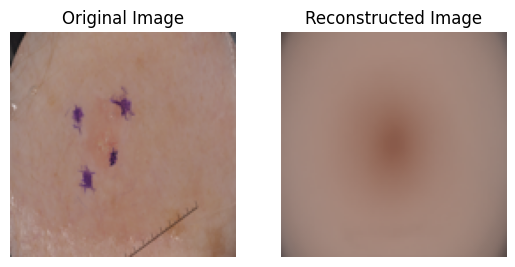

In [35]:
# confront the original image with the reconstructed image for a random image
random_index = np.random.randint(0, len(dataset))
random_image = dataset[random_index].reshape(1, -1)
reconstructed_image = pca.inverse_transform(pca.transform(random_image))

fig, ax = plt.subplots(1, 2)
ax[0].imshow(random_image.reshape(128, 128, 3))
ax[0].set_title('Original Image')
ax[0].axis('off')
reconstructed_image_int = reconstructed_image.astype(int)
ax[1].imshow(reconstructed_image_int.reshape(128, 128, 3))
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')
plt.show()

In [36]:
## save the pca model to a file
#with open('pca.pkl', 'wb') as f:
#    pickle.dump(pca, f)

In [37]:
train = pca.transform(dataset)
df_train = pd.DataFrame(train, index=index)
df_train.index = [ind+"_train" for ind in index]
df_train

,0,1
ISIC_0010093_train,1760.290794,-1862.208457
ISIC_0010201_train,140.528276,4439.853673
ISIC_0014929_train,6121.246014,-1.570556
ISIC_0008992_train,2667.844898,-987.146217
ISIC_0012671_train,4058.042549,-604.382763
...,...,...
ISIC_0010498_train,4119.999919,1678.564224
ISIC_0010479_train,784.892722,-378.788439
ISIC_0013783_train,-6384.533250,779.331494
ISIC_0000364_train,-6979.027485,2946.165010


In [38]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_train, x=0, y=1)
fig.show()

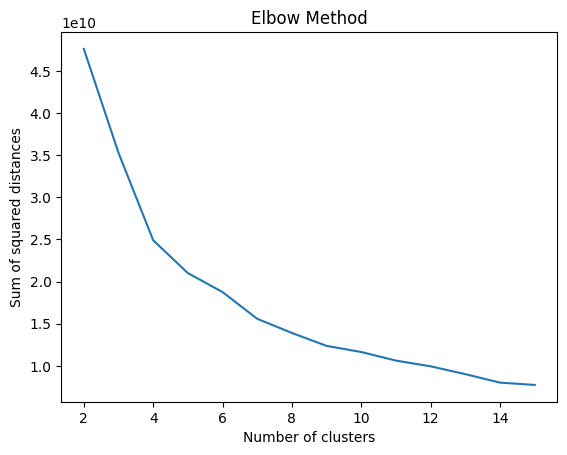

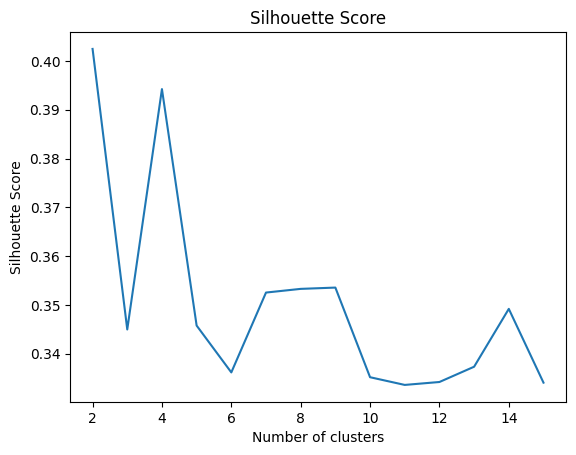

,0,1,cluster
ISIC_0010093_train,1760.290794,-1862.208457,0
ISIC_0010201_train,140.528276,4439.853673,3
ISIC_0014929_train,6121.246014,-1.570556,1
ISIC_0008992_train,2667.844898,-987.146217,0
ISIC_0012671_train,4058.042549,-604.382763,0
...,...,...,...
ISIC_0010498_train,4119.999919,1678.564224,0
ISIC_0010479_train,784.892722,-378.788439,0
ISIC_0013783_train,-6384.533250,779.331494,2
ISIC_0000364_train,-6979.027485,2946.165010,2


In [39]:
# use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# calculate the sum of squared distances for each number of clusters
ssd = []
silhouette = []
for i in range(2, 16):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_train.values)
    ssd.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_train.values, kmeans.labels_))

# plot the sum of squared distances
plt.plot(range(2, 16), ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method')
plt.show()

# plot the silhouette score
plt.plot(range(2, 16), silhouette)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')   
plt.show()

# use 3 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(df_train.values)
df_train['cluster'] = kmeans.labels_
df_train['cluster'] = df_train['cluster'].astype(str)
df_train

In [40]:
# create a 3d scatter plot of the first 3 components using plotly
fig = px.scatter(df_train, x=0, y=1, color='cluster')
fig.show()

In [41]:
df_train.to_csv('train_pca_red_skincancer.csv')

In [42]:
## reduce to 3D
#import pacmap
#mapper = pacmap.PaCMAP(n_components=2, n_neighbors=2)
#X = df_train.values
#X_2d = mapper.fit_transform(X)
#
#df_train_2d = pd.DataFrame(X_2d, columns=['x', 'y'], index=df_train.index)
#df_train_2d

In [43]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_train_2d, x='x', y='y')
#fig.show()

In [44]:
## reduce dimensionality a second time using UMAP, use 3 dimensions
#import umap
#reducer = umap.UMAP(n_components=2)
#embedding = reducer.fit_transform(df_train)
#embedding.shape
#
#df_umap = pd.DataFrame(embedding, index=df_train.index, columns=['x', 'y'])
#df_umap

In [45]:
## use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
#
## calculate the sum of squared distances for each number of clusters
#ssd = []
#silhouette = []
#for i in range(2, 16):
#    kmeans = KMeans(n_clusters=i, random_state=0)
#    kmeans.fit(embedding)
#    ssd.append(kmeans.inertia_)
#    silhouette.append(silhouette_score(embedding, kmeans.labels_))
#
## plot the sum of squared distances
#plt.plot(range(2, 16), ssd)
#plt.xlabel('Number of clusters')
#plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method')
#plt.show()
#
## plot the silhouette score
#plt.plot(range(2, 16), silhouette)
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score')   
#plt.show()
#
## use 3 clusters
#kmeans = KMeans(n_clusters=6, random_state=0)
#kmeans.fit(embedding)
#df_umap['cluster'] = kmeans.labels_
#df_umap['cluster'] = df_umap['cluster'].astype(str)
#df_umap

In [46]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_umap, x='x', y='y', color='cluster')
#fig.show()

In [47]:
#df_umap.to_csv('train_umap_skincancer.csv')

In [48]:
#import trimap
#mapper = trimap.TRIMAP(n_dims=2)
#embedding = mapper.fit_transform(df_train)
#embedding.shape
#
#df_trimap = pd.DataFrame(embedding, index=df_train.index, columns=['x', 'y'])
#df_trimap

In [49]:
## use elbow method to determine the optimal number of clusters then use kmeans to cluster the data
#from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
#
## calculate the sum of squared distances for each number of clusters
#ssd = []
#silhouette = []
#for i in range(2, 16):
#    kmeans = KMeans(n_clusters=i, random_state=0)
#    kmeans.fit(embedding)
#    ssd.append(kmeans.inertia_)
#    silhouette.append(silhouette_score(embedding, kmeans.labels_))
#
## plot the sum of squared distances
#plt.plot(range(2, 16), ssd)
#plt.xlabel('Number of clusters')
#plt.ylabel('Sum of squared distances')
#plt.title('Elbow Method')
#plt.show()
#
## plot the silhouette score
#plt.plot(range(2, 16), silhouette)
#plt.xlabel('Number of clusters')
#plt.ylabel('Silhouette Score')
#plt.title('Silhouette Score')   
#plt.show()
#
## use 3 clusters
#kmeans = KMeans(n_clusters=3, random_state=0)
#kmeans.fit(embedding)
#df_trimap['cluster'] = kmeans.labels_
#df_trimap['cluster'] = df_trimap['cluster'].astype(str)
#df_trimap

In [50]:
## create a 3d scatter plot of the first 3 components using plotly
#fig = px.scatter(df_trimap, x='x', y='y', color='cluster')
#fig.show()

In [51]:
# create a dataset for the test data
output = create_dataset(data_dir_test)

In [52]:
dataset = np.concatenate(output[0], axis=0)
index = output[1]

In [53]:
test = pca.transform(dataset)
df_test = pd.DataFrame(test, index=index)
df_test.index = [ind+"_test" for ind in index]
df_test.to_csv('test_pca.csv')
df_test

,0,1
ISIC_0016028_test,47.213664,-2430.412775
ISIC_0014944_test,651.651007,3353.761034
ISIC_0015990_test,-5314.415765,-259.061348
ISIC_0016057_test,-4354.532263,-2216.080814
ISIC_0015089_test,-782.593538,9327.482921
...,...,...
ISIC_0015215_test,5310.604381,902.617536
ISIC_0015142_test,-169.951316,3376.501424
ISIC_0016015_test,-3664.238762,-1142.596676
ISIC_0012722_test,-5083.560107,-856.174618


In [54]:
df_test['cluster'] = kmeans.predict(df_test.values)
df_test['cluster'] = df_test['cluster'].astype(str)
df_test.to_csv('test_pca_red_skincancer.csv')
df_test

,0,1,cluster
ISIC_0016028_test,47.213664,-2430.412775,0
ISIC_0014944_test,651.651007,3353.761034,3
ISIC_0015990_test,-5314.415765,-259.061348,2
ISIC_0016057_test,-4354.532263,-2216.080814,2
ISIC_0015089_test,-782.593538,9327.482921,3
...,...,...,...
ISIC_0015215_test,5310.604381,902.617536,1
ISIC_0015142_test,-169.951316,3376.501424,3
ISIC_0016015_test,-3664.238762,-1142.596676,2
ISIC_0012722_test,-5083.560107,-856.174618,2


In [55]:
fig = px.scatter(df_test, x=0, y=1, color='cluster')
fig.show()